# Week 9 — Gradient Boost (Scikit‑learn)


In [1]:

CSV_PATH = "Chronic_Kidney_Dsease_data.csv"   
TARGET_COL = "classification"                  
RANDOM_STATE = 42
CV_FOLDS = 5

# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier
from scipy.stats import loguniform, randint

import warnings
warnings.filterwarnings("ignore")
np.random.seed(RANDOM_STATE)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 1) Load Data

In [2]:
df = pd.read_csv(CSV_PATH)

df.columns = [c.strip() for c in df.columns]
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip()
    
print("Shape:", df.shape)
display(df.head())


Shape: (1659, 54)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


## 2) Target Prep (Binary Classification Mapping) + Train/Valid Split

In [3]:
TARGET_COL = "Diagnosis"  

assert TARGET_COL in df.columns, (
    f"TARGET_COL '{TARGET_COL}' not in columns: {df.columns.tolist()}"
)

uniq_vals = df[TARGET_COL].dropna().astype(str).str.strip().unique().tolist()
print("Unique raw label values:", uniq_vals)

y_raw = df[TARGET_COL].astype(str).str.strip()
X = df.drop(columns=[TARGET_COL])

def to01(series):
    s = series.astype(str).str.strip()
    s_low = s.str.lower()
    uniq = sorted(s_low.dropna().unique().tolist())
    if len(uniq) != 2:
        raise ValueError(f"Target must be binary; got {len(uniq)} classes: {uniq}")

    if any("ckd" in u for u in uniq):
        pos_mask = s_low.str.contains("ckd")
        return pos_mask.astype(int)

    pairs = [
        ({"ckd","notckd"}, {"ckd":1, "notckd":0}),
        ({"yes","no"}, {"yes":1, "no":0}),
        ({"y","n"}, {"y":1, "n":0}),
        ({"1","0"}, {"1":1, "0":0}),
        ({"positive","negative"}, {"positive":1, "negative":0}),
        ({"pos","neg"}, {"pos":1, "neg":0}),
        ({"disease","healthy"}, {"disease":1, "healthy":0}),
    ]
    for keys, mapping in pairs:
        if set(uniq) <= keys:
            return s_low.map(mapping).astype(int)

    print(f"Warning: falling back to alphabetical mapping {uniq[0]}->0, {uniq[1]}->1")
    mapping = {uniq[0]:0, uniq[1]:1}
    return s_low.map(mapping).astype(int)

y = to01(y_raw)

print("Class distribution:", y.value_counts(normalize=True).round(3).to_dict())

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_valid.shape


Unique raw label values: ['1', '0']
Class distribution: {1: 0.919, 0: 0.081}


((1327, 53), (332, 53))

## 3) Preprocessing (Impute + OneHot)

In [4]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  
])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
]) 


Numeric: 52 | Categorical: 1


## 4) Helper: Evaluation Function 

In [5]:
def evaluate_cls(pipe, X_tr, y_tr, X_te, y_te):
    pred_tr = pipe.predict(X_tr)
    pred_te = pipe.predict(X_te)
    out = {
        "accuracy_tr": accuracy_score(y_tr, pred_tr),
        "accuracy_te": accuracy_score(y_te, pred_te),
        "f1_te": f1_score(y_te, pred_te, average="binary"),
        "precision_te": precision_score(y_te, pred_te, zero_division=0),
        "recall_te": recall_score(y_te, pred_te, zero_division=0),
    }
    try:
        proba = pipe.predict_proba(X_te)[:,1]
        out["roc_auc_te"] = roc_auc_score(y_te, proba)
    except Exception:
        pass
    return out


## 5) Baseline Gradient Boosting

In [6]:
gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)
pipe_base = Pipeline([("prep", preprocess), ("gb", gb_base)])
pipe_base.fit(X_train, y_train)
metrics_base = evaluate_cls(pipe_base, X_train, y_train, X_valid, y_valid)
metrics_base


{'accuracy_tr': 1.0,
 'accuracy_te': 0.9216867469879518,
 'f1_te': 0.9577922077922078,
 'precision_te': 0.9485530546623794,
 'recall_te': 0.9672131147540983,
 'roc_auc_te': 0.9545840922890103}

## 6) Learning Rate × Number of Estimators Sweep

,accuracy_tr,accuracy_te,f1_te,precision_te,recall_te,roc_auc_te,learning_rate,n_estimators
0,0.956292,0.921687,0.958466,0.934579,0.983607,0.953734,0.02,100
1,0.991711,0.933735,0.964630,0.946372,0.983607,0.957863,0.02,300
2,1.000000,0.936747,0.965854,0.958065,0.973770,0.956770,0.02,600
3,0.987943,0.933735,0.964630,0.946372,0.983607,0.956770,0.05,100
4,1.000000,0.936747,0.965964,0.955128,0.977049,0.952155,0.05,300
5,1.000000,0.939759,0.967532,0.958199,0.977049,0.950455,0.05,600
6,1.000000,0.921687,0.957792,0.948553,0.967213,0.954584,0.10,100
7,1.000000,0.927711,0.961165,0.948882,0.973770,0.949970,0.10,300
8,1.000000,0.930723,0.962723,0.951923,0.973770,0.946205,0.10,600
9,1.000000,0.936747,0.965964,0.955128,0.977049,0.953370,0.20,100


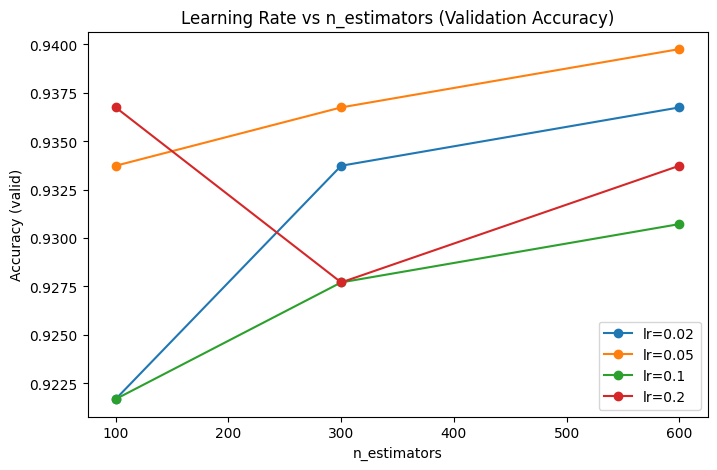

In [7]:
lrs = [0.02, 0.05, 0.1, 0.2]
n_estimators_grid = [100, 300, 600]

rows = []
for lr in lrs:
    for ne in n_estimators_grid:
        est = GradientBoostingClassifier(learning_rate=lr, n_estimators=ne, random_state=RANDOM_STATE)
        pipe = Pipeline([("prep", preprocess), ("gb", est)])
        pipe.fit(X_train, y_train)
        m = evaluate_cls(pipe, X_train, y_train, X_valid, y_valid)
        m.update({"learning_rate": lr, "n_estimators": ne})
        rows.append(m)

df_lr = pd.DataFrame(rows)
display(df_lr.sort_values(["learning_rate","n_estimators"]).reset_index(drop=True))

plt.figure(figsize=(8,5))
for lr in lrs:
    sub = df_lr[df_lr["learning_rate"] == lr]
    plt.plot(sub["n_estimators"], sub["accuracy_te"], marker="o", label=f"lr={lr}")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy (valid)")
plt.title("Learning Rate vs n_estimators (Validation Accuracy)")
plt.legend()
plt.show()


## 7) Depth / Leaves Regularization

,accuracy_tr,accuracy_te,f1_te,precision_te,recall_te,roc_auc_te,max_depth,min_samples_leaf
0,0.978146,0.927711,0.961415,0.943218,0.980328,0.959320,2,1
1,0.980407,0.927711,0.961415,0.943218,0.980328,0.962234,2,5
2,0.981161,0.927711,0.961415,0.943218,0.980328,0.959441,2,10
3,1.000000,0.921687,0.957792,0.948553,0.967213,0.954584,3,1
4,1.000000,0.936747,0.966074,0.952229,0.980328,0.961384,3,5
5,0.998493,0.933735,0.964169,0.957929,0.970492,0.958106,3,10
6,1.000000,0.927711,0.961165,0.948882,0.973770,0.949241,4,1
7,1.000000,0.924699,0.959481,0.948718,0.970492,0.953613,4,5
8,1.000000,0.930723,0.962602,0.954839,0.970492,0.957620,4,10
9,1.000000,0.918675,0.956522,0.939873,0.973770,0.947784,6,1


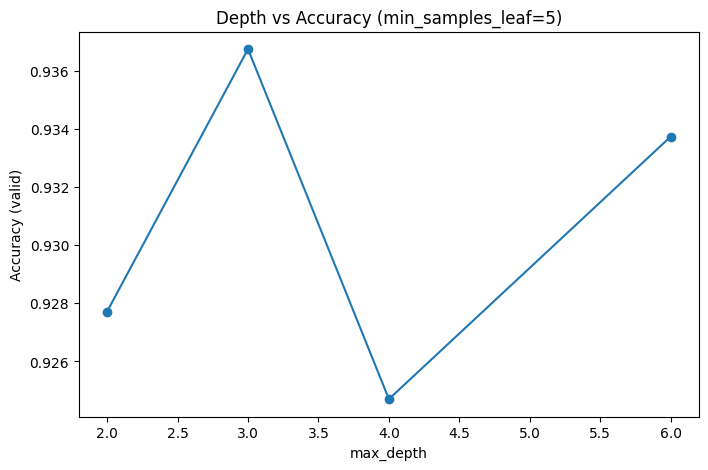

In [8]:
depths = [2, 3, 4, 6]
min_leaves = [1, 5, 10]

rows = []
for d in depths:
    for ml in min_leaves:
        est = GradientBoostingClassifier(max_depth=d, min_samples_leaf=ml, random_state=RANDOM_STATE)
        pipe = Pipeline([("prep", preprocess), ("gb", est)])
        pipe.fit(X_train, y_train)
        m = evaluate_cls(pipe, X_train, y_train, X_valid, y_valid)
        m.update({"max_depth": d, "min_samples_leaf": ml})
        rows.append(m)

df_depth = pd.DataFrame(rows)
display(df_depth)

best_ml = int(df_depth.sort_values("accuracy_te", ascending=False).iloc[0]["min_samples_leaf"])
sub = df_depth[df_depth["min_samples_leaf"] == best_ml]
plt.figure(figsize=(8,5))
plt.plot(sub["max_depth"], sub["accuracy_te"], marker="o")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (valid)")
plt.title(f"Depth vs Accuracy (min_samples_leaf={best_ml})")
plt.show()


## 8) Stochastic Gradient Boosting (subsample, max_features)

In [9]:
subsamps = [0.6, 0.8, 1.0]
max_feats = [None, 0.5, 0.8]

rows = []
for ss in subsamps:
    for mf in max_feats:
        est = GradientBoostingClassifier(subsample=ss, max_features=mf, random_state=RANDOM_STATE)
        pipe = Pipeline([("prep", preprocess), ("gb", est)])
        pipe.fit(X_train, y_train)
        m = evaluate_cls(pipe, X_train, y_train, X_valid, y_valid)
        m.update({"subsample": ss, "max_features": mf})
        rows.append(m)

df_stoch = pd.DataFrame(rows)
display(df_stoch)


,accuracy_tr,accuracy_te,f1_te,precision_te,recall_te,roc_auc_te,subsample,max_features
0,1.000000,0.924699,0.959612,0.945860,0.973770,0.946327,0.6,NaN
1,0.999246,0.945783,0.970779,0.961415,0.980328,0.961870,0.6,0.5
2,0.999246,0.927711,0.961290,0.946032,0.977049,0.949484,0.6,0.8
3,1.000000,0.930723,0.962843,0.949045,0.977049,0.947541,0.8,NaN
4,1.000000,0.927711,0.961039,0.951768,0.970492,0.952763,0.8,0.5
5,1.000000,0.939759,0.967638,0.955272,0.980328,0.956527,0.8,0.8
6,1.000000,0.921687,0.957792,0.948553,0.967213,0.954584,1.0,NaN
7,0.999246,0.933735,0.964401,0.952077,0.977049,0.957498,1.0,0.5
8,0.999246,0.930723,0.962843,0.949045,0.977049,0.952155,1.0,0.8


## 9) Histogram-based GBDT (Early Stopping + L2)

In [10]:
hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=None,             
    max_leaf_nodes=31,
    min_samples_leaf=20,
    l2_regularization=0.0,      
    early_stopping=True,
    random_state=RANDOM_STATE
)
pipe_hgb = Pipeline([("prep", preprocess), ("hgb", hgb)])
pipe_hgb.fit(X_train, y_train)
metrics_hgb = evaluate_cls(pipe_hgb, X_train, y_train, X_valid, y_valid)
metrics_hgb


{'accuracy_tr': 0.9947249434815373,
 'accuracy_te': 0.9156626506024096,
 'f1_te': 0.9548387096774194,
 'precision_te': 0.9396825396825397,
 'recall_te': 0.9704918032786886,
 'roc_auc_te': 0.9489981785063752}

## 10) Hyperparameter Tuning (RandomizedSearchCV on HGB)

In [11]:
param_dist = {
    "hgb__learning_rate": loguniform(1e-3, 3e-1),
    "hgb__max_leaf_nodes": randint(15, 63),
    "hgb__min_samples_leaf": randint(5, 60),
    "hgb__l2_regularization": loguniform(1e-4, 1e-1),
}
pipe = Pipeline([("prep", preprocess), ("hgb", HistGradientBoostingClassifier(early_stopping=True, random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best CV ROC AUC:", search.best_score_)

best_pipe = search.best_estimator_
tuned_metrics = evaluate_cls(best_pipe, X_train, y_train, X_valid, y_valid)
tuned_metrics


Best params: {'hgb__l2_regularization': np.float64(0.0014040609919104441), 'hgb__learning_rate': np.float64(0.2726353246361054), 'hgb__max_leaf_nodes': 17, 'hgb__min_samples_leaf': 41}
Best CV ROC AUC: 0.9615422154584268


{'accuracy_tr': 0.9902034664657121,
 'accuracy_te': 0.9216867469879518,
 'f1_te': 0.9580645161290322,
 'precision_te': 0.9428571428571428,
 'recall_te': 0.9737704918032787,
 'roc_auc_te': 0.9494839101396478}

## 11) Permutation Importance (Validation Set)

,feature,importance_mean,importance_std
0,num__PatientID,0.023494,0.008498
1,num__GFR,0.014157,0.007975
2,num__QualityOfLifeScore,0.003916,0.003027
3,num__BUNLevels,0.003614,0.007229
4,num__SerumCreatinine,0.003614,0.007229
5,num__FastingBloodSugar,0.003313,0.003916
6,num__ACR,0.003012,0.003012
7,num__ProteinInUrine,0.002711,0.002502
8,num__DiastolicBP,0.002711,0.002842
9,num__PhysicalActivity,0.002711,0.002502


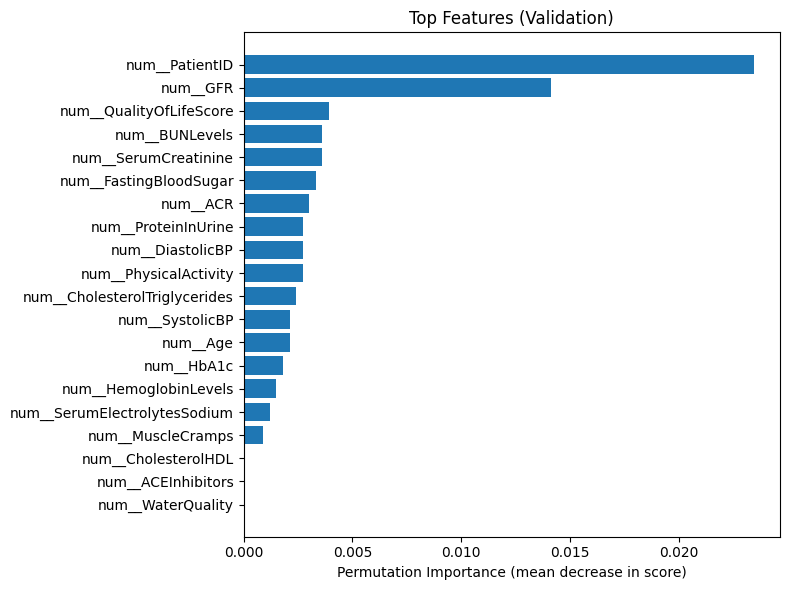

In [12]:
perm = permutation_importance(best_pipe, X_valid, y_valid, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp_idx = perm.importances_mean.argsort()[::-1]
feature_names = list(best_pipe.named_steps["prep"].get_feature_names_out())

imp_df = pd.DataFrame({
    "feature": np.array(feature_names)[imp_idx],
    "importance_mean": perm.importances_mean[imp_idx],
    "importance_std": perm.importances_std[imp_idx],
})
display(imp_df.head(25))

plt.figure(figsize=(8,6))
topn = min(20, len(imp_df))
plt.barh(imp_df["feature"][:topn][::-1], imp_df["importance_mean"][:topn][::-1])
plt.xlabel("Permutation Importance (mean decrease in score)")
plt.title("Top Features (Validation)")
plt.tight_layout()
plt.show()


## 12) Diagnostics

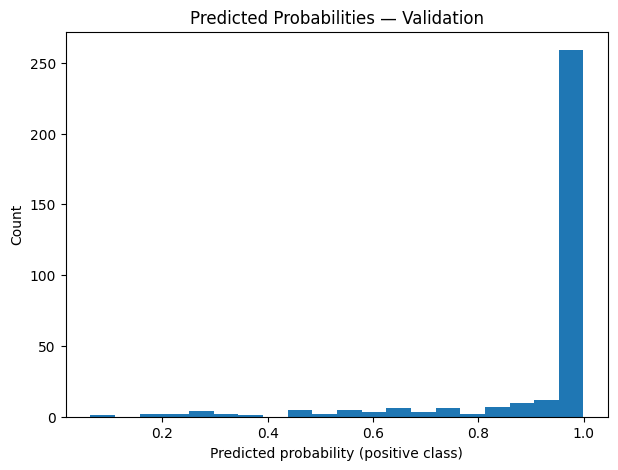

In [13]:
try:
    proba = best_pipe.predict_proba(X_valid)[:,1]
    plt.figure(figsize=(7,5))
    plt.hist(proba, bins=20)
    plt.xlabel("Predicted probability (positive class)")
    plt.ylabel("Count")
    plt.title("Predicted Probabilities — Validation")
    plt.show()
except Exception as e:
    print("Could not compute probabilities:", e)


## Conclusion

This week’s analysis applied Gradient Boosting methods to predict whether patients were diagnosed with Chronic Kidney Disease (CKD) based on clinical and lifestyle indicators.
Three models were compared: a baseline GradientBoostingClassifier, a Histogram-based Gradient Boosting (HGB) model with early stopping, and a tuned HGB model optimized through RandomizedSearchCV.

Across all three models, Gradient Boosting demonstrated strong predictive power for identifying Chronic Kidney Disease. The baseline GradientBoostingClassifier achieved an accuracy of approximately 0.92, an F1 score of 0.958, and an ROC AUC of 0.955, showing excellent overall balance between precision and recall. The Histogram-based Gradient Boosting model with early stopping performed similarly, with slightly lower accuracy (0.916) but maintained high sensitivity (recall ≈ 0.97), indicating its strength in correctly detecting positive CKD cases. After hyperparameter tuning, the optimized HistGradientBoostingClassifier reached the best overall balance, achieving 0.922 accuracy, 0.958 F1, and 0.949 ROC AUC, supported by the best cross-validation ROC AUC of 0.962. The tuned model’s parameters,such as a moderate learning rate (≈0.27), smaller leaf size, and mild L2 regularization helped improve stability and generalization while maintaining high recall, confirming its reliability for medical prediction tasks where identifying true CKD cases is critical.

The tuned model achieved the best overall balance, matching the baseline’s accuracy while slightly improving recall and maintaining a high ROC AUC (≈ 0.95).
Its optimal parameters (learning_rate ≈ 0.27, max_leaf_nodes = 17, min_samples_leaf = 41, l2_regularization ≈ 0.0014) indicate a compact, well-regularized model that avoids overfitting despite strong training accuracy (0.99).